# Introduction

New York City has an extraordinarily diverse population. It is the largest city in the United States with a long history of international immigration. It is one of the few cities in the country in which four different racial/ethnic groups each make up at least 10 percent of the population. According to the 2010 decennial census, 33 percent of New York City residents are white, 26 percent are Hispanic, 26 percent are black, and 13 percent are Asian. While the diversity of New York City’s population is not reflected in many of the city’s neighborhoods, over the past 20 years the racial and ethnic makeup of the city’s neighborhoods (census tracts) has increasingly come to look more like that of the city itself. Between 2000 and 2010 the city as a whole became more Hispanic and Asian. While the population at large has declined the past few years, the city’s Asian population has, meanwhile, become more concentrated. 

According to the 2000 US Census, there are approximately 57,000 Bangladeshis in the United States and the New York metropolitan area is home to the largest Bangladeshi population. From 1990 to 2000, New York City’s Bangladeshi population increased by 471% (from 4,955 to 28,269). About 85% of Bangladeshi New Yorkers were foreign-born, and 77% of these immigrants came to the US from 1990 to 2000. Some 30% of all Bangladeshi immigrants in the city in 2000 were naturalized US citizens – compared with 45% of all foreign-born city residents. 

## Business Problem

The location of food service business will impact its success nearly as much as the menu. If the restaurant is in the wrong place, we cannot attract the number of customers we will need in order to stay in business. The same is true if our location is inundated with competitors, or has poor visibility, or is hard to find. There are many things that must be considered as we look for a location in which to open our business.

The objective of the Capstone project is to analyze and select the best locations in the city of New York to open a new Bengali/Bangladeshi restaurant, using data science methodology and instruments such as data analysis and visualization.

## Data

We will need the following data to solve the problem: 
- New York City data containing the neighborhoods and boroughs, 
- Latitude and longitude coordinates of those neighborhoods, 
- Venue data, particularly data related to restaurants.

New York City data containing the neighborhoods and boroughs will be obtained from the open data source: https://cocl.us/new_york_dataset. Next, we will get the geographical coordinates of the neighborhoods (latitude and longitude) using the Python Geocoder package.

We will use the Foursquare API to get the venue data for the neighborhoods defined at the previous step. Foursquare has one of the largest databases of 105+ million places, 900+ venue categories, 30+ attribute fields, and over 150,000 developers use this application. Among the many Foursquare API provided categories of the venue data, we are particularly interested in the restaurant data to solve the business problem defined above.

## Methodology

- Collect data from https://cocl.us/new_york_dataset.
- Clean and process data into a dataframe.
- Use FourSquare to locate all venues.
- Filter by Bengali restaurants.
- Sort data based on rankings.
- Visually assess data using graphing from Python libraries.


## Import all required libraries

In [1]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import requests # library to handle requests

from bs4 import BeautifulSoup
import os

!conda install -c conda-forge folium=0.5.0 --yes
import folium # map rendering library

!conda install -c conda-forge geopy --yes
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
import requests # library to handle requests

# Matplotlib and associated plotting modules
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
%matplotlib inline

import seaborn as sns

print('Libraries imported.')  

Solving environment: ...working... failed with initial frozen solve. Retrying with flexible solve.
Solving environment: ...working... done

## Package Plan ##

  environment location: D:\deeplearning\Anaconda3

  added / updated specs:
    - folium=0.5.0


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    ca-certificates-2019.11.28 |       hecc5488_0         182 KB  conda-forge
    certifi-2019.11.28         |           py36_0         148 KB  conda-forge
    conda-4.8.0                |           py36_1         3.0 MB  conda-forge
    folium-0.5.0               |             py_0          45 KB  conda-forge
    openssl-1.1.1d             |       hfa6e2cd_0         4.7 MB  conda-forge
    ------------------------------------------------------------
                                           Total:         8.1 MB

The following packages will be UPDATED:

  ca-certificates    pkgs/main::ca-ce

'mysql' is not recognized as an internal or external command,
operable program or batch file.
'mysql' is not recognized as an internal or external command,
operable program or batch file.


==> WARNING: A newer version of conda exists. <==
  current version: 4.7.12
  latest version: 4.8.1

Please update conda by running

    $ conda update -n base -c defaults conda


'mysql' is not recognized as an internal or external command,
operable program or batch file.
'mysql' is not recognized as an internal or external command,
operable program or batch file.


Solving environment: ...working... done

# All requested packages already installed.



'mysql' is not recognized as an internal or external command,
operable program or batch file.
'mysql' is not recognized as an internal or external command,
operable program or batch file.
'mysql' is not recognized as an internal or external command,
operable program or batch file.
'mysql' is not recognized as an internal or external command,
operable program or batch file.


Libraries imported.


## Foursquare variables

In [2]:
# Define Foursquare Credentials and Version

CLIENT_ID = 'NQD5LQA11PKF0MA2PNGHUW0JGJWWFBTLQEXXKYQFNI5YTBB3' # Foursquare ID
CLIENT_SECRET = 'XUYOEXEJ4S33IGBZBNV2ZVH4ZQSQMV5TSWE1ZE5C4KV5T2VM' # Foursquare Secret
VERSION = '20180605' # Foursquare API version

## Functions for later use

In [3]:
def geo_location(address):
    # get geo location of address
    geolocator = Nominatim(user_agent="foursquare_agent")
    location = geolocator.geocode(address)
    latitude = location.latitude
    longitude = location.longitude
    return latitude,longitude

def get_venues(lat,lng):
    #set variables
    radius=400
    LIMIT=100
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
    # get all the data
    results = requests.get(url).json()
    venue_data=results['response']['groups'][0]['items']
    venue_details=[]
    for row in venue_data:
        try:
            venue_id=row['venue']['id']
            venue_name=row['venue']['name']
            venue_category=row['venue']['categories'][0]['name']
            venue_details.append([venue_id,venue_name,venue_category])
        except KeyError:
            pass
    column_names=['ID','Name','Category']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df

def get_venue_details(venue_id):
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/{}?&client_id={}&client_secret={}&v={}'.format(
            venue_id,
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION)
    # get all the data
    results = requests.get(url).json()
    print(results)
    venue_data=results['response']['venue']
    venue_details=[]
    try:
        venue_id=venue_data['id']
        venue_name=venue_data['name']
        venue_likes=venue_data['likes']['count']
        venue_rating=venue_data['rating']
        venue_tips=venue_data['tips']['count']
        venue_details.append([venue_id,venue_name,venue_likes,venue_rating,venue_tips])
    except KeyError:
        pass
    column_names=['ID','Name','Likes','Rating','Tips']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df

def get_new_york_data():
    url='https://cocl.us/new_york_dataset'
    resp=requests.get(url).json()
    # all data is present in features label
    features=resp['features']
    # define the dataframe columns
    column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 
    # instantiate the dataframe
    new_york_data = pd.DataFrame(columns=column_names)
    for data in features:
        borough = data['properties']['borough'] 
        neighborhood_name = data['properties']['name']
        neighborhood_latlon = data['geometry']['coordinates']
        neighborhood_lat = neighborhood_latlon[1]
        neighborhood_lon = neighborhood_latlon[0]
        new_york_data = new_york_data.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)
    return new_york_data

## Retrieve NYC data

In [4]:
ny_data = get_new_york_data()
ny_data.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


In [5]:
ny_data.shape

(306, 4)

There are total 306 different Neighborhoods in New York.  

## Initial Data Analysis

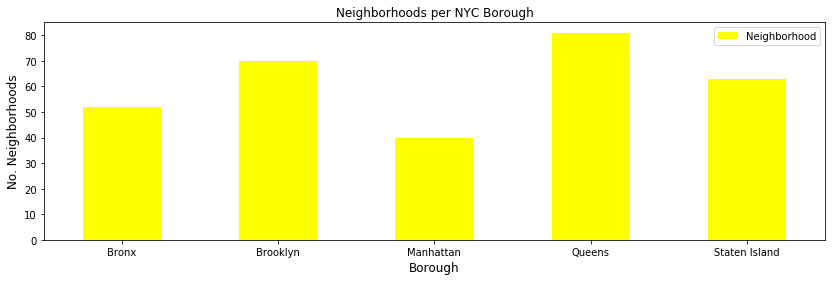

In [11]:
clr = "yellow"
ny_data.groupby('Borough')['Neighborhood'].count().plot.bar(figsize=(14,4), color=clr)
plt.title('Neighborhoods per NYC Borough', fontsize = 12)
plt.xlabel('Borough', fontsize = 12)
plt.ylabel('No. Neighborhoods',fontsize = 12)
plt.xticks(rotation = 'horizontal')
plt.legend()
plt.show()

## Analyze how many Bengali restaurants there are in each neighborhood and borough

In [13]:
# prepare neighborhood list that contains bangladeshi restaurants
column_names=['Borough', 'Neighborhood', 'ID','Name']
bangladeshi_rest_ny=pd.DataFrame(columns=column_names)
count=1
for row in ny_data.values.tolist():
    Borough, Neighborhood, Latitude, Longitude=row
    venues = get_venues(Latitude,Longitude)
    bangladeshi_restaurants=venues[venues['Category']=='Bangladeshi Restaurant']   
    print('(',count,'/',len(ny_data),')','Bangladeshi Restaurants in '+Neighborhood+', '+Borough+':'+str(len(bangladeshi_restaurants)))
    print(row)
    for resturant_detail in bangladeshi_restaurants.values.tolist():
        id, name , category=resturant_detail
        bangladeshi_rest_ny = bangladeshi_rest_ny.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name
                                               }, ignore_index=True)
    count+=1

( 1 / 306 ) Bangladeshi Restaurants in Wakefield, Bronx:0
['Bronx', 'Wakefield', 40.89470517661, -73.84720052054902]
( 2 / 306 ) Bangladeshi Restaurants in Co-op City, Bronx:0
['Bronx', 'Co-op City', 40.87429419303012, -73.82993910812398]
( 3 / 306 ) Bangladeshi Restaurants in Eastchester, Bronx:0
['Bronx', 'Eastchester', 40.887555677350775, -73.82780644716412]
( 4 / 306 ) Bangladeshi Restaurants in Fieldston, Bronx:0
['Bronx', 'Fieldston', 40.89543742690383, -73.90564259591682]
( 5 / 306 ) Bangladeshi Restaurants in Riverdale, Bronx:0
['Bronx', 'Riverdale', 40.890834493891305, -73.9125854610857]
( 6 / 306 ) Bangladeshi Restaurants in Kingsbridge, Bronx:0
['Bronx', 'Kingsbridge', 40.88168737120521, -73.90281798724604]
( 7 / 306 ) Bangladeshi Restaurants in Marble Hill, Manhattan:0
['Manhattan', 'Marble Hill', 40.87655077879964, -73.91065965862981]
( 8 / 306 ) Bangladeshi Restaurants in Woodlawn, Bronx:0
['Bronx', 'Woodlawn', 40.89827261213805, -73.86731496814176]
( 9 / 306 ) Bangladesh

( 66 / 306 ) Bangladeshi Restaurants in Cobble Hill, Brooklyn:0
['Brooklyn', 'Cobble Hill', 40.687919722485574, -73.99856139218463]
( 67 / 306 ) Bangladeshi Restaurants in Carroll Gardens, Brooklyn:0
['Brooklyn', 'Carroll Gardens', 40.680540231076485, -73.99465372828006]
( 68 / 306 ) Bangladeshi Restaurants in Red Hook, Brooklyn:0
['Brooklyn', 'Red Hook', 40.676253230250886, -74.0127589747356]
( 69 / 306 ) Bangladeshi Restaurants in Gowanus, Brooklyn:0
['Brooklyn', 'Gowanus', 40.673931143187154, -73.99444087145339]
( 70 / 306 ) Bangladeshi Restaurants in Fort Greene, Brooklyn:0
['Brooklyn', 'Fort Greene', 40.68852726018977, -73.97290574369092]
( 71 / 306 ) Bangladeshi Restaurants in Park Slope, Brooklyn:0
['Brooklyn', 'Park Slope', 40.67232052268197, -73.97705030183924]
( 72 / 306 ) Bangladeshi Restaurants in Cypress Hills, Brooklyn:0
['Brooklyn', 'Cypress Hills', 40.68239101144211, -73.87661596457296]
( 73 / 306 ) Bangladeshi Restaurants in East New York, Brooklyn:0
['Brooklyn', 'East

( 127 / 306 ) Bangladeshi Restaurants in Gramercy, Manhattan:0
['Manhattan', 'Gramercy', 40.737209832715, -73.98137594833541]
( 128 / 306 ) Bangladeshi Restaurants in Battery Park City, Manhattan:0
['Manhattan', 'Battery Park City', 40.71193198394565, -74.01686930508617]
( 129 / 306 ) Bangladeshi Restaurants in Financial District, Manhattan:0
['Manhattan', 'Financial District', 40.70710710727048, -74.0106654452127]
( 130 / 306 ) Bangladeshi Restaurants in Astoria, Queens:0
['Queens', 'Astoria', 40.76850859335492, -73.91565374304234]
( 131 / 306 ) Bangladeshi Restaurants in Woodside, Queens:0
['Queens', 'Woodside', 40.74634908860222, -73.90184166838284]
( 132 / 306 ) Bangladeshi Restaurants in Jackson Heights, Queens:0
['Queens', 'Jackson Heights', 40.75198138007367, -73.88282109164365]
( 133 / 306 ) Bangladeshi Restaurants in Elmhurst, Queens:0
['Queens', 'Elmhurst', 40.744048505122024, -73.88165622288388]
( 134 / 306 ) Bangladeshi Restaurants in Howard Beach, Queens:0
['Queens', 'Howa

( 191 / 306 ) Bangladeshi Restaurants in Belle Harbor, Queens:0
['Queens', 'Belle Harbor', 40.57615556543109, -73.8540175039252]
( 192 / 306 ) Bangladeshi Restaurants in Rockaway Park, Queens:0
['Queens', 'Rockaway Park', 40.58034295646131, -73.84153370226186]
( 193 / 306 ) Bangladeshi Restaurants in Somerville, Queens:0
['Queens', 'Somerville', 40.59771061565768, -73.79664750844047]
( 194 / 306 ) Bangladeshi Restaurants in Brookville, Queens:0
['Queens', 'Brookville', 40.66000322733613, -73.75175310731153]
( 195 / 306 ) Bangladeshi Restaurants in Bellaire, Queens:0
['Queens', 'Bellaire', 40.73301404027834, -73.73889198912481]
( 196 / 306 ) Bangladeshi Restaurants in North Corona, Queens:0
['Queens', 'North Corona', 40.7540709990489, -73.85751790676447]
( 197 / 306 ) Bangladeshi Restaurants in Forest Hills Gardens, Queens:0
['Queens', 'Forest Hills Gardens', 40.7146110815117, -73.8410221123401]
( 198 / 306 ) Bangladeshi Restaurants in St. George, Staten Island:0
['Staten Island', 'St. 

( 251 / 306 ) Bangladeshi Restaurants in Midtown South, Manhattan:0
['Manhattan', 'Midtown South', 40.7485096643122, -73.98871313285247]
( 252 / 306 ) Bangladeshi Restaurants in Richmond Town, Staten Island:0
['Staten Island', 'Richmond Town', 40.56960594275505, -74.1340572986257]
( 253 / 306 ) Bangladeshi Restaurants in Shore Acres, Staten Island:0
['Staten Island', 'Shore Acres', 40.60971934079284, -74.06667766061771]
( 254 / 306 ) Bangladeshi Restaurants in Clifton, Staten Island:0
['Staten Island', 'Clifton', 40.61917845202843, -74.072642445484]
( 255 / 306 ) Bangladeshi Restaurants in Concord, Staten Island:0
['Staten Island', 'Concord', 40.6044731896879, -74.08402364740358]
( 256 / 306 ) Bangladeshi Restaurants in Emerson Hill, Staten Island:0
['Staten Island', 'Emerson Hill', 40.606794394801, -74.09776206972522]
( 257 / 306 ) Bangladeshi Restaurants in Randall Manor, Staten Island:0
['Staten Island', 'Randall Manor', 40.63563000681151, -74.09805062373887]
( 258 / 306 ) Banglades

In [14]:
#bangladeshi_rest_ny.to_csv('bangladeshi_rest_ny_tocsv1.csv') # Save the information so far to a .csv file due to limited calls on FourSquare
bangladeshi_rest_ny.to_csv('bangladeshi_rest_ny_tocsv1.csv') 

In [15]:
bangladeshi_ny = pd.read_csv('bangladeshi_rest_ny_tocsv1.csv')
bangladeshi_rest_ny.tail()

,Borough,Neighborhood,ID,Name


In [16]:
bangladeshi_rest_ny.shape

(0, 4)

**In Foursquare database, we got 0 Bangladeshi Restaurants across the New York City. This should be quite good for business as no pure Bangladeshi restaurant is available to cater to the increasing Bangladeshi population. For further analysis, we will check for Indian restaurants which are similar to the Bangladeshi cuisine.**

In [17]:
# prepare neighborhood list that contains indian restaurants
column_names=['Borough', 'Neighborhood', 'ID','Name']
indian_rest_ny=pd.DataFrame(columns=column_names)
count=1
for row in ny_data.values.tolist():
    Borough, Neighborhood, Latitude, Longitude=row
    venues = get_venues(Latitude,Longitude)
    indian_restaurants=venues[venues['Category']=='Indian Restaurant']   
    print('(',count,'/',len(ny_data),')','Indian Restaurants in '+Neighborhood+', '+Borough+':'+str(len(indian_restaurants)))
    print(row)
    for resturant_detail in indian_restaurants.values.tolist():
        id, name , category=resturant_detail
        indian_rest_ny = indian_rest_ny.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name
                                               }, ignore_index=True)
    count+=1

( 1 / 306 ) Indian Restaurants in Wakefield, Bronx:0
['Bronx', 'Wakefield', 40.89470517661, -73.84720052054902]
( 2 / 306 ) Indian Restaurants in Co-op City, Bronx:0
['Bronx', 'Co-op City', 40.87429419303012, -73.82993910812398]
( 3 / 306 ) Indian Restaurants in Eastchester, Bronx:0
['Bronx', 'Eastchester', 40.887555677350775, -73.82780644716412]
( 4 / 306 ) Indian Restaurants in Fieldston, Bronx:0
['Bronx', 'Fieldston', 40.89543742690383, -73.90564259591682]
( 5 / 306 ) Indian Restaurants in Riverdale, Bronx:0
['Bronx', 'Riverdale', 40.890834493891305, -73.9125854610857]
( 6 / 306 ) Indian Restaurants in Kingsbridge, Bronx:0
['Bronx', 'Kingsbridge', 40.88168737120521, -73.90281798724604]
( 7 / 306 ) Indian Restaurants in Marble Hill, Manhattan:0
['Manhattan', 'Marble Hill', 40.87655077879964, -73.91065965862981]
( 8 / 306 ) Indian Restaurants in Woodlawn, Bronx:1
['Bronx', 'Woodlawn', 40.89827261213805, -73.86731496814176]
( 9 / 306 ) Indian Restaurants in Norwood, Bronx:0
['Bronx', '

( 68 / 306 ) Indian Restaurants in Red Hook, Brooklyn:0
['Brooklyn', 'Red Hook', 40.676253230250886, -74.0127589747356]
( 69 / 306 ) Indian Restaurants in Gowanus, Brooklyn:1
['Brooklyn', 'Gowanus', 40.673931143187154, -73.99444087145339]
( 70 / 306 ) Indian Restaurants in Fort Greene, Brooklyn:1
['Brooklyn', 'Fort Greene', 40.68852726018977, -73.97290574369092]
( 71 / 306 ) Indian Restaurants in Park Slope, Brooklyn:0
['Brooklyn', 'Park Slope', 40.67232052268197, -73.97705030183924]
( 72 / 306 ) Indian Restaurants in Cypress Hills, Brooklyn:0
['Brooklyn', 'Cypress Hills', 40.68239101144211, -73.87661596457296]
( 73 / 306 ) Indian Restaurants in East New York, Brooklyn:0
['Brooklyn', 'East New York', 40.669925700847045, -73.88069863917366]
( 74 / 306 ) Indian Restaurants in Starrett City, Brooklyn:0
['Brooklyn', 'Starrett City', 40.64758905230874, -73.87936970045875]
( 75 / 306 ) Indian Restaurants in Canarsie, Brooklyn:0
['Brooklyn', 'Canarsie', 40.63556432797428, -73.90209269778966]


( 132 / 306 ) Indian Restaurants in Jackson Heights, Queens:0
['Queens', 'Jackson Heights', 40.75198138007367, -73.88282109164365]
( 133 / 306 ) Indian Restaurants in Elmhurst, Queens:0
['Queens', 'Elmhurst', 40.744048505122024, -73.88165622288388]
( 134 / 306 ) Indian Restaurants in Howard Beach, Queens:0
['Queens', 'Howard Beach', 40.65422527738487, -73.8381376460028]
( 135 / 306 ) Indian Restaurants in Corona, Queens:0
['Queens', 'Corona', 40.74238175015667, -73.85682497345258]
( 136 / 306 ) Indian Restaurants in Forest Hills, Queens:0
['Queens', 'Forest Hills', 40.72526378216503, -73.84447500788983]
( 137 / 306 ) Indian Restaurants in Kew Gardens, Queens:1
['Queens', 'Kew Gardens', 40.7051790354148, -73.82981905825703]
( 138 / 306 ) Indian Restaurants in Richmond Hill, Queens:0
['Queens', 'Richmond Hill', 40.69794731471763, -73.83183321446887]
( 139 / 306 ) Indian Restaurants in Flushing, Queens:0
['Queens', 'Flushing', 40.76445419697846, -73.83177300329582]
( 140 / 306 ) Indian Re

( 199 / 306 ) Indian Restaurants in New Brighton, Staten Island:0
['Staten Island', 'New Brighton', 40.64061455913511, -74.08701650516625]
( 200 / 306 ) Indian Restaurants in Stapleton, Staten Island:0
['Staten Island', 'Stapleton', 40.62692762538176, -74.07790192660066]
( 201 / 306 ) Indian Restaurants in Rosebank, Staten Island:0
['Staten Island', 'Rosebank', 40.61530494652761, -74.06980526716141]
( 202 / 306 ) Indian Restaurants in West Brighton, Staten Island:0
['Staten Island', 'West Brighton', 40.63187892654607, -74.1071817826561]
( 203 / 306 ) Indian Restaurants in Grymes Hill, Staten Island:0
['Staten Island', 'Grymes Hill', 40.624184791313006, -74.08724819983729]
( 204 / 306 ) Indian Restaurants in Todt Hill, Staten Island:0
['Staten Island', 'Todt Hill', 40.59706851814673, -74.1113288180088]
( 205 / 306 ) Indian Restaurants in South Beach, Staten Island:0
['Staten Island', 'South Beach', 40.58024741350956, -74.0795529253982]
( 206 / 306 ) Indian Restaurants in Port Richmond, 

( 260 / 306 ) Indian Restaurants in Remsen Village, Brooklyn:0
['Brooklyn', 'Remsen Village', 40.652117451793494, -73.91665331978048]
( 261 / 306 ) Indian Restaurants in New Lots, Brooklyn:0
['Brooklyn', 'New Lots', 40.6627442796966, -73.88511776379292]
( 262 / 306 ) Indian Restaurants in Paerdegat Basin, Brooklyn:0
['Brooklyn', 'Paerdegat Basin', 40.63131755039667, -73.90233474295836]
( 263 / 306 ) Indian Restaurants in Mill Basin, Brooklyn:0
['Brooklyn', 'Mill Basin', 40.61597423962336, -73.91515391550404]
( 264 / 306 ) Indian Restaurants in Jamaica Hills, Queens:2
['Queens', 'Jamaica Hills', 40.71145964370482, -73.79646462081593]
( 265 / 306 ) Indian Restaurants in Utopia, Queens:0
['Queens', 'Utopia', 40.73350025429757, -73.79671678028349]
( 266 / 306 ) Indian Restaurants in Pomonok, Queens:0
['Queens', 'Pomonok', 40.73493618075478, -73.80486120040537]
( 267 / 306 ) Indian Restaurants in Astoria Heights, Queens:0
['Queens', 'Astoria Heights', 40.7703173929982, -73.89467996270574]
(

In [18]:
#indian_rest_ny.to_csv('indian_rest_ny_tocsv1.csv') # Save the information so far to a .csv file due to limited calls on FourSquare
indian_rest_ny.to_csv('indian_rest_ny_tocsv1.csv') 

In [19]:
indian_ny = pd.read_csv('indian_rest_ny_tocsv1.csv')
indian_rest_ny.tail()

,Borough,Neighborhood,ID,Name
34,Queens,Jamaica Hills,4c69c4b58e7c0f47d48de00f,Ghoroa Sweets & Restaurant
35,Manhattan,Sutton Place,4a63bfb4f964a520b3c51fe3,Chola Eclectic Indian Cuisine
36,Manhattan,Sutton Place,4fe4fb50c2eee335e4fea69d,Moti Mahal Delux
37,Manhattan,Sutton Place,3fd66200f964a52099e91ee3,Dawat
38,Queens,Sunnyside Gardens,4c48da9f3013a59356c5f0e1,Saffron Garden


In [20]:
indian_rest_ny.shape

(39, 4)

In Foursquare database, we got 39 Indian Restaurants across the New York City. 

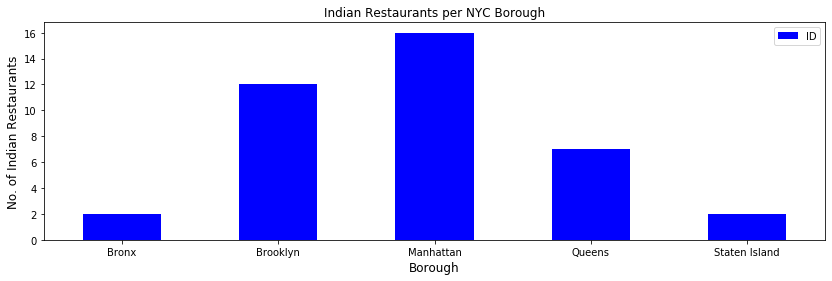

In [22]:
clr = "blue"
indian_rest_ny.groupby('Borough')['ID'].count().plot.bar(figsize=(14,4), color=clr)
plt.title('Indian Restaurants per NYC Borough', fontsize = 12)
plt.xlabel('Borough', fontsize = 12)
plt.ylabel('No. of Indian Restaurants', fontsize=12)
plt.xticks(rotation = 'horizontal')
plt.legend()
plt.show()

We see that although Manhattan had the least number of neighborhoods, it does have the highest number of Indian restaurants.

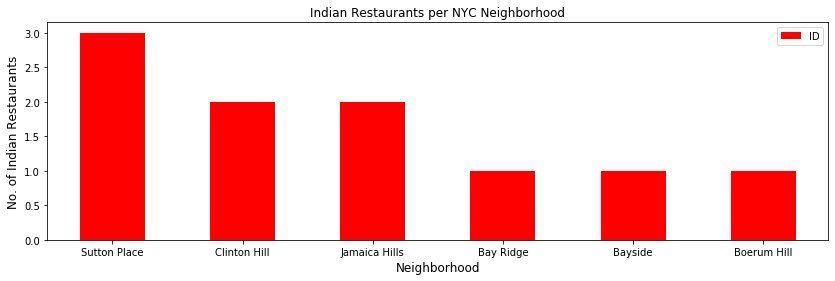

In [23]:
NOofNeigh = 6 # top number for graphing all the same past 6
clr = "red"
indian_rest_ny.groupby('Neighborhood')['ID'].count().nlargest(NOofNeigh).plot.bar(figsize=(14,4), color=clr)
plt.title('Indian Restaurants per NYC Neighborhood', fontsize = 12)
plt.xlabel('Neighborhood', fontsize = 12)
plt.ylabel('No. of Indian Restaurants', fontsize=12)
plt.xticks(rotation = 'horizontal')
plt.legend()
plt.show()

Additionally, we see how many restaurants the top 6 neighborhoods have. The neighborhood of Sutton Place has the highest number of Indian restaurants and is actually located in the boroughs of Manhattan.

In [25]:
indian_rest_ny[indian_rest_ny['Neighborhood']=='Sutton Place']

,Borough,Neighborhood,ID,Name
35,Manhattan,Sutton Place,4a63bfb4f964a520b3c51fe3,Chola Eclectic Indian Cuisine
36,Manhattan,Sutton Place,4fe4fb50c2eee335e4fea69d,Moti Mahal Delux
37,Manhattan,Sutton Place,3fd66200f964a52099e91ee3,Dawat


Now, get the ranking of each restaurant.

In [26]:
column_names=['Borough', 'Neighborhood', 'ID','Name','Likes','Rating','Tips']
indian_rest_stats_ny=pd.DataFrame(columns=column_names)
count=1
for row in indian_rest_ny.values.tolist():
    Borough,Neighborhood,ID,Name=row
    try:
        venue_details=get_venue_details(ID)
        print(venue_details)
        id,name,likes,rating,tips=venue_details.values.tolist()[0]
    except IndexError:
        print('No data available for id=',ID)
        # we will assign 0 value for these resturants as they may have been 
        # recently opened or details does not exist in FourSquare Database
        id,name,likes,rating,tips=[0]*5
    print('(',count,'/',len(indian_rest_ny),')','processed')
    indian_rest_stats_ny = indian_rest_stats_ny.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name,
                                                'Likes' : likes,
                                                'Rating' : rating,
                                                'Tips' : tips
                                               }, ignore_index=True)
    count+=1
indian_rest_stats_ny.tail()

{'meta': {'code': 200, 'requestId': '5e1ca1d440a7ea001c4e15f5'}, 'response': {'venue': {'id': '4c0448d9310fc9b6bf1dc761', 'name': 'Curry Spot', 'contact': {'phone': '7187085900', 'formattedPhone': '(718) 708-5900'}, 'location': {'address': '4268 Katonah Ave', 'crossStreet': 'E 235 Street', 'lat': 40.897624941880906, 'lng': -73.86714729157393, 'labeledLatLngs': [{'label': 'display', 'lat': 40.897624941880906, 'lng': -73.86714729157393}], 'postalCode': '10470', 'cc': 'US', 'city': 'Bronx', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['4268 Katonah Ave (E 235 Street)', 'Bronx, NY 10470', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/curry-spot/4c0448d9310fc9b6bf1dc761', 'categories': [{'id': '4bf58dd8d48988d10f941735', 'name': 'Indian Restaurant', 'pluralName': 'Indian Restaurants', 'shortName': 'Indian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/indian_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount':

{'meta': {'code': 200, 'requestId': '5e1ca24aad1ab4001cc25c38'}, 'response': {'venue': {'id': '545835a1498e820edc6f636f', 'name': 'Bombay Grill', 'contact': {'phone': '7184912500', 'formattedPhone': '(718) 491-2500'}, 'location': {'address': '8716 3rd Ave', 'lat': 40.622371, 'lng': -74.03179899999999, 'labeledLatLngs': [{'label': 'display', 'lat': 40.622371, 'lng': -74.03179899999999}], 'postalCode': '11209', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['8716 3rd Ave', 'Brooklyn, NY 11209', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/bombay-grill/545835a1498e820edc6f636f', 'categories': [{'id': '4bf58dd8d48988d10f941735', 'name': 'Indian Restaurant', 'pluralName': 'Indian Restaurants', 'shortName': 'Indian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/indian_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 4}, 'price': {'tier': 2, 'message': 'Moderate', 'currency': '

{'meta': {'code': 200, 'requestId': '5e1ca24978a484001b23128b'}, 'response': {'venue': {'id': '5169f5c4e4b0c7fcb77a0f3c', 'name': 'Agra Heights', 'contact': {'phone': '7184435700', 'formattedPhone': '(718) 443-5700'}, 'location': {'address': '226 Wilson Ave', 'crossStreet': 'btwn Harman & Himrod St', 'lat': 40.698094445626104, 'lng': -73.92135507234042, 'labeledLatLngs': [{'label': 'display', 'lat': 40.698094445626104, 'lng': -73.92135507234042}], 'postalCode': '11237', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['226 Wilson Ave (btwn Harman & Himrod St)', 'Brooklyn, NY 11237', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/agra-heights/5169f5c4e4b0c7fcb77a0f3c', 'categories': [{'id': '4bf58dd8d48988d10f941735', 'name': 'Indian Restaurant', 'pluralName': 'Indian Restaurants', 'shortName': 'Indian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/indian_', 'suffix': '.png'}, 'primary': True}], 'verified': 

{'meta': {'code': 200, 'requestId': '5e1ca24a78a484001b231640'}, 'response': {'venue': {'id': '4b8ffc16f964a520246e33e3', 'name': 'Curry Heights', 'contact': {'phone': '7182609000', 'formattedPhone': '(718) 260-9000', 'twitter': 'curryheights'}, 'location': {'address': '151 Remsen St', 'crossStreet': 'btwn Court St & Clinton St', 'lat': 40.69357223828141, 'lng': -73.99226545349896, 'labeledLatLngs': [{'label': 'display', 'lat': 40.69357223828141, 'lng': -73.99226545349896}], 'postalCode': '11201', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['151 Remsen St (btwn Court St & Clinton St)', 'Brooklyn, NY 11201', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/curry-heights/4b8ffc16f964a520246e33e3', 'categories': [{'id': '4bf58dd8d48988d10f941735', 'name': 'Indian Restaurant', 'pluralName': 'Indian Restaurants', 'shortName': 'Indian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/indian_', 'suffix': '.png'}, 

{'meta': {'code': 200, 'requestId': '5e1ca2283907e7002268dc98'}, 'response': {'venue': {'id': '52f18573498ec2c34e830ffd', 'name': "Kanan's Indian Restaurant", 'contact': {'phone': '7183693777', 'formattedPhone': '(718) 369-3777'}, 'location': {'address': '452 3rd Ave', 'crossStreet': '9th Street', 'lat': 40.671890999999995, 'lng': -73.99094000000001, 'labeledLatLngs': [{'label': 'display', 'lat': 40.671890999999995, 'lng': -73.99094000000001}], 'postalCode': '11215', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['452 3rd Ave (9th Street)', 'Brooklyn, NY 11215', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/kanans-indian-restaurant/52f18573498ec2c34e830ffd', 'categories': [{'id': '4bf58dd8d48988d10f941735', 'name': 'Indian Restaurant', 'pluralName': 'Indian Restaurants', 'shortName': 'Indian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/indian_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 

{'meta': {'code': 200, 'requestId': '5e1ca2660de0d9001b3b9022'}, 'response': {'venue': {'id': '57596dad498e732300496b23', 'name': 'Dosa Royale', 'contact': {'phone': '7185763800', 'formattedPhone': '(718) 576-3800'}, 'location': {'address': '258 Dekalb Ave', 'lat': 40.689466368706604, 'lng': -73.96870434089776, 'labeledLatLngs': [{'label': 'display', 'lat': 40.689466368706604, 'lng': -73.96870434089776}], 'postalCode': '11205', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['258 Dekalb Ave', 'New York, NY 11205', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/dosa-royale/57596dad498e732300496b23', 'categories': [{'id': '4bf58dd8d48988d10f941735', 'name': 'Indian Restaurant', 'pluralName': 'Indian Restaurants', 'shortName': 'Indian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/indian_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 22}, 'url': 'http://www.dosaroyale.com', 

{'meta': {'code': 200, 'requestId': '5e1ca25dedbcad001b25029b'}, 'response': {'venue': {'id': '568d3902498e619efcbc3f58', 'name': 'Spice & Grill', 'contact': {}, 'location': {'address': '441 Myrtle Ave', 'crossStreet': 'Waverly', 'lat': 40.693389, 'lng': -73.968028, 'labeledLatLngs': [{'label': 'display', 'lat': 40.693389, 'lng': -73.968028}], 'postalCode': '11205', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['441 Myrtle Ave (Waverly)', 'Brooklyn, NY 11205', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/spice--grill/568d3902498e619efcbc3f58', 'categories': [{'id': '4bf58dd8d48988d10f941735', 'name': 'Indian Restaurant', 'pluralName': 'Indian Restaurants', 'shortName': 'Indian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/indian_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 6}, 'price': {'tier': 2, 'message': 'Moderate', 'currency': '$'}, 'likes': {'count': 19, 'gro

{'meta': {'code': 200, 'requestId': '5e1ca24e78a484001b232865'}, 'response': {'venue': {'id': '543870ec498ec64de510608d', 'name': 'Masala Grill', 'contact': {}, 'location': {'address': 'Atlantic Avenue', 'crossStreet': '3rd Avenue', 'lat': 40.68554017378092, 'lng': -73.98120188318653, 'labeledLatLngs': [{'label': 'display', 'lat': 40.68554017378092, 'lng': -73.98120188318653}], 'postalCode': '11217', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['Atlantic Avenue (3rd Avenue)', 'Brooklyn, NY 11217', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/masala-grill/543870ec498ec64de510608d', 'categories': [{'id': '4bf58dd8d48988d10f941735', 'name': 'Indian Restaurant', 'pluralName': 'Indian Restaurants', 'shortName': 'Indian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/indian_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 14}, 'url': 'http://masalagrillbk.com', 'price': {'tie

{'meta': {'code': 200, 'requestId': '5e1ca22f923935001ba939ce'}, 'response': {'venue': {'id': '4bb93b70cf2fc9b6fe64a002', 'name': 'Gandhi Fine Indian Cuisine', 'contact': {'phone': '7182827012', 'formattedPhone': '(718) 282-7012'}, 'location': {'address': '2032 Bedford Ave', 'crossStreet': 'btwn Clarkson Ave & Parkside Ave', 'lat': 40.65516762218564, 'lng': -73.95632450081226, 'labeledLatLngs': [{'label': 'display', 'lat': 40.65516762218564, 'lng': -73.95632450081226}], 'postalCode': '11226', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['2032 Bedford Ave (btwn Clarkson Ave & Parkside Ave)', 'Brooklyn, NY 11226', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/gandhi-fine-indian-cuisine/4bb93b70cf2fc9b6fe64a002', 'categories': [{'id': '4bf58dd8d48988d10f941735', 'name': 'Indian Restaurant', 'pluralName': 'Indian Restaurants', 'shortName': 'Indian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/indian_', 's

{'meta': {'code': 200, 'requestId': '5e1ca241b9a389001b5449d3'}, 'response': {'venue': {'id': '5631511b498e3d6d7e0a4df0', 'name': 'Tikka Indian Grill', 'contact': {'phone': '7187682262', 'formattedPhone': '(718) 768-2262'}, 'location': {'address': '185 Grand Street', 'lat': 40.71434305888687, 'lng': -73.96090327883888, 'labeledLatLngs': [{'label': 'display', 'lat': 40.71434305888687, 'lng': -73.96090327883888}], 'postalCode': '11211', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['185 Grand Street', 'Brooklyn, NY 11211', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/tikka-indian-grill/5631511b498e3d6d7e0a4df0', 'categories': [{'id': '4bf58dd8d48988d10f941735', 'name': 'Indian Restaurant', 'pluralName': 'Indian Restaurants', 'shortName': 'Indian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/indian_', 'suffix': '.png'}, 'primary': True}], 'verified': True, 'stats': {'tipCount': 29}, 'url': 'http://www.ti

{'meta': {'code': 200, 'requestId': '5e1ca290b57e88001b8e51fc'}, 'response': {'venue': {'id': '527ed6a5498e91b0d7e9b8f4', 'name': 'Mahal Kita', 'contact': {'phone': '7185991516', 'formattedPhone': '(718) 599-1516', 'twitter': 'mahalkitany'}, 'location': {'address': '184 Havemeyer St', 'crossStreet': 'btwn S 4th St & S 3rd St', 'lat': 40.71055514758327, 'lng': -73.95813477484435, 'labeledLatLngs': [{'label': 'display', 'lat': 40.71055514758327, 'lng': -73.95813477484435}], 'postalCode': '11211', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['184 Havemeyer St (btwn S 4th St & S 3rd St)', 'Brooklyn, NY 11211', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/mahal-kita/527ed6a5498e91b0d7e9b8f4', 'categories': [{'id': '4bf58dd8d48988d10f941735', 'name': 'Indian Restaurant', 'pluralName': 'Indian Restaurants', 'shortName': 'Indian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/indian_', 'suffix': '.png'}, 'prim

{'meta': {'code': 200, 'requestId': '5e1ca224760a7f001b6ca316'}, 'response': {'venue': {'id': '4ae7876ef964a5201eac21e3', 'name': 'Kismat Indian Restaurant', 'contact': {'phone': '2127958633', 'formattedPhone': '(212) 795-8633', 'twitter': 'kismatindian'}, 'location': {'address': '603 Fort Washington Ave', 'crossStreet': '187th St', 'lat': 40.855221723964846, 'lng': -73.93696683600031, 'labeledLatLngs': [{'label': 'display', 'lat': 40.855221723964846, 'lng': -73.93696683600031}], 'postalCode': '10040', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['603 Fort Washington Ave (187th St)', 'New York, NY 10040', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/kismat-indian-restaurant/4ae7876ef964a5201eac21e3', 'categories': [{'id': '4bf58dd8d48988d10f941735', 'name': 'Indian Restaurant', 'pluralName': 'Indian Restaurants', 'shortName': 'Indian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/indian_', 'suffix': '

{'meta': {'code': 200, 'requestId': '5e1ca20a71c428001b5e718f'}, 'response': {'venue': {'id': '54c2bd96498eaf5142e3fe92', 'name': 'Clove Indian Restaurant & Bar', 'contact': {'phone': '6469186644', 'formattedPhone': '(646) 918-6644', 'twitter': 'cloveindian'}, 'location': {'address': '1592 Amsterdam Ave', 'crossStreet': 'btwn 139th St & 138th St', 'lat': 40.82128, 'lng': -73.95062, 'labeledLatLngs': [{'label': 'display', 'lat': 40.82128, 'lng': -73.95062}], 'postalCode': '10031', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['1592 Amsterdam Ave (btwn 139th St & 138th St)', 'New York, NY 10031', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/clove-indian-restaurant--bar/54c2bd96498eaf5142e3fe92', 'categories': [{'id': '4bf58dd8d48988d10f941735', 'name': 'Indian Restaurant', 'pluralName': 'Indian Restaurants', 'shortName': 'Indian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/indian_', 'suffix': '.png'}, 

{'meta': {'code': 200, 'requestId': '5e1ca255d03993001b34d034'}, 'response': {'venue': {'id': '529d382a11d2dd5ef107e641', 'name': 'Chapati House - NYC', 'contact': {'phone': '2127497200', 'formattedPhone': '(212) 749-7200', 'twitter': 'chapatihousenyc'}, 'location': {'address': '3153 Broadway', 'crossStreet': 'Tiemann Pl.', 'lat': 40.81457249971737, 'lng': -73.95915381671377, 'labeledLatLngs': [{'label': 'display', 'lat': 40.81457249971737, 'lng': -73.95915381671377}], 'postalCode': '10027', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['3153 Broadway (Tiemann Pl.)', 'New York, NY 10027', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/chapati-house--nyc/529d382a11d2dd5ef107e641', 'categories': [{'id': '4bf58dd8d48988d10f941735', 'name': 'Indian Restaurant', 'pluralName': 'Indian Restaurants', 'shortName': 'Indian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/indian_', 'suffix': '.png'}, 'primary': True}

{'meta': {'code': 200, 'requestId': '5e1ca26d0de0d9001b3bb4ab'}, 'response': {'venue': {'id': '4b0dec08f964a520ae5223e3', 'name': 'Alachi Masala', 'contact': {'phone': '2128747420', 'formattedPhone': '(212) 874-7420', 'twitter': 'alachimasala', 'facebook': '833664873419022', 'facebookName': 'Poona Indian Restaurant'}, 'location': {'address': '488 Amsterdam Ave Frnt 1', 'lat': 40.7861663, 'lng': -73.9764143, 'labeledLatLngs': [{'label': 'display', 'lat': 40.7861663, 'lng': -73.9764143}], 'postalCode': '10024', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['488 Amsterdam Ave Frnt 1', 'New York, NY 10024', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/alachi-masala/4b0dec08f964a520ae5223e3', 'categories': [{'id': '4bf58dd8d48988d10f941735', 'name': 'Indian Restaurant', 'pluralName': 'Indian Restaurants', 'shortName': 'Indian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/indian_', 'suffix': '.png'}, 'prima

{'meta': {'code': 200, 'requestId': '5e1ca2313907e70022690815'}, 'response': {'venue': {'id': '5aeb49d267f62b002ca5a9b5', 'name': 'Masala King', 'contact': {}, 'location': {'address': '64 E 34th St', 'crossStreet': 'btwn Park & Madison Ave', 'lat': 40.74718410480507, 'lng': -73.98185309164937, 'labeledLatLngs': [{'label': 'display', 'lat': 40.74718410480507, 'lng': -73.98185309164937}], 'postalCode': '10016', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['64 E 34th St (btwn Park & Madison Ave)', 'New York, NY 10016', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/masala-king/5aeb49d267f62b002ca5a9b5', 'categories': [{'id': '4bf58dd8d48988d10f941735', 'name': 'Indian Restaurant', 'pluralName': 'Indian Restaurants', 'shortName': 'Indian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/indian_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 2}, 'price': {'tier': 2, 'message': 

{'meta': {'code': 200, 'requestId': '5e1ca28947b43d00236a3f2f'}, 'response': {'venue': {'id': '56c931b2cd10407d3ecbefda', 'name': 'Ananda', 'contact': {}, 'location': {'address': '210 Thompson St', 'crossStreet': 'btwn W 3rd & Bleecker Sts', 'lat': 40.72883889496238, 'lng': -73.9993364782382, 'labeledLatLngs': [{'label': 'display', 'lat': 40.72883889496238, 'lng': -73.9993364782382}], 'postalCode': '10012', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['210 Thompson St (btwn W 3rd & Bleecker Sts)', 'New York, NY 10012', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/ananda/56c931b2cd10407d3ecbefda', 'categories': [{'id': '4bf58dd8d48988d10f941735', 'name': 'Indian Restaurant', 'pluralName': 'Indian Restaurants', 'shortName': 'Indian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/indian_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 20}, 'url': 'http://www.ahimsa.nyc', '

{'meta': {'code': 200, 'requestId': '5e1ca25e7828ae001be873bb'}, 'response': {'venue': {'id': '4bbb9dbded7776b0e1ad3e51', 'name': 'Tamarind TriBeCa', 'contact': {'phone': '2127759000', 'formattedPhone': '(212) 775-9000', 'facebook': '201503306550753', 'facebookName': 'Tamarind Tribeca'}, 'location': {'address': '99 Hudson St', 'crossStreet': 'at Franklin St', 'lat': 40.71921117375622, 'lng': -74.00872657957527, 'labeledLatLngs': [{'label': 'display', 'lat': 40.71921117375622, 'lng': -74.00872657957527}], 'postalCode': '10013', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['99 Hudson St (at Franklin St)', 'New York, NY 10013', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/tamarind-tribeca/4bbb9dbded7776b0e1ad3e51', 'categories': [{'id': '4bf58dd8d48988d10f941735', 'name': 'Indian Restaurant', 'pluralName': 'Indian Restaurants', 'shortName': 'Indian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/indian_',

{'meta': {'code': 200, 'requestId': '5e1ca2160f596800223ca6fe'}, 'response': {'venue': {'id': '4d24b812836f5481518645f7', 'name': 'Doaba Deli', 'contact': {'phone': '2122222636', 'formattedPhone': '(212) 222-2636'}, 'location': {'address': '945 Columbus Ave', 'crossStreet': 'btw W 106th & 107th', 'lat': 40.799513471286254, 'lng': -73.96266286944638, 'labeledLatLngs': [{'label': 'display', 'lat': 40.799513471286254, 'lng': -73.96266286944638}], 'postalCode': '10025', 'cc': 'US', 'neighborhood': 'Upper West Side', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['945 Columbus Ave (btw W 106th & 107th)', 'New York, NY 10025', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/doaba-deli/4d24b812836f5481518645f7', 'categories': [{'id': '4bf58dd8d48988d10f941735', 'name': 'Indian Restaurant', 'pluralName': 'Indian Restaurants', 'shortName': 'Indian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/indian_', 'suffix': '.png'}, 'pri

{'meta': {'code': 200, 'requestId': '5e1ca20d211536001c6f971c'}, 'response': {'venue': {'id': '5b770657c0cacb002c89bc63', 'name': 'The Kati Roll Company', 'contact': {}, 'location': {'address': '22 Maiden Ln', 'lat': 40.70911435070483, 'lng': -74.0090911929708, 'labeledLatLngs': [{'label': 'display', 'lat': 40.70911435070483, 'lng': -74.0090911929708}], 'postalCode': '10038', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['22 Maiden Ln', 'New York, NY 10038', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/the-kati-roll-company/5b770657c0cacb002c89bc63', 'categories': [{'id': '4bf58dd8d48988d10f941735', 'name': 'Indian Restaurant', 'pluralName': 'Indian Restaurants', 'shortName': 'Indian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/indian_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 2}, 'price': {'tier': 2, 'message': 'Moderate', 'currency': '$'}, 'likes': {'count': 1

{'meta': {'code': 200, 'requestId': '5e1ca27b949393001b2de9bc'}, 'response': {'venue': {'id': '5782c9ce498edde587f5aa14', 'name': 'Tikka Indian Grill', 'contact': {'phone': '7184801307', 'formattedPhone': '(718) 480-1307'}, 'location': {'address': '119-30 Metropolitan Ave', 'lat': 40.70587364181698, 'lng': -73.83094233462995, 'labeledLatLngs': [{'label': 'display', 'lat': 40.70587364181698, 'lng': -73.83094233462995}], 'postalCode': '11415', 'cc': 'US', 'city': 'Queens', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['119-30 Metropolitan Ave', 'Queens, NY 11415', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/tikka-indian-grill/5782c9ce498edde587f5aa14', 'categories': [{'id': '4bf58dd8d48988d10f941735', 'name': 'Indian Restaurant', 'pluralName': 'Indian Restaurants', 'shortName': 'Indian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/indian_', 'suffix': '.png'}, 'primary': True}], 'verified': True, 'stats': {'tipCount': 2}, 'url': 'http

{'meta': {'code': 200, 'requestId': '5e1ca2bfdf2774001c6e9b4d'}, 'response': {'venue': {'id': '4b3a8aa5f964a520996925e3', 'name': 'Sajni 026', 'contact': {'phone': '7182750606', 'formattedPhone': '(718) 275-0606'}, 'location': {'address': '9810 Queens Blvd', 'crossStreet': '65th Rd.', 'lat': 40.728123, 'lng': -73.858071, 'labeledLatLngs': [{'label': 'display', 'lat': 40.728123, 'lng': -73.858071}], 'postalCode': '11374', 'cc': 'US', 'city': 'Rego Park', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['9810 Queens Blvd (65th Rd.)', 'Rego Park, NY 11374', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/sajni-026/4b3a8aa5f964a520996925e3', 'categories': [{'id': '4bf58dd8d48988d10f941735', 'name': 'Indian Restaurant', 'pluralName': 'Indian Restaurants', 'shortName': 'Indian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/indian_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 6}, 'price': {'tier': 1, 'message':

{'meta': {'code': 200, 'requestId': '5e1ca25ed03993001b34fbb5'}, 'response': {'venue': {'id': '57a27a37498e68b1928c8c66', 'name': 'Spice Rack', 'contact': {'phone': '7182735843', 'formattedPhone': '(718) 273-5843'}, 'location': {'address': '1791 Victory Blvd', 'crossStreet': 'Manor Road', 'lat': 40.61333, 'lng': -74.123173, 'labeledLatLngs': [{'label': 'display', 'lat': 40.61333, 'lng': -74.123173}], 'postalCode': '10314', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['1791 Victory Blvd (Manor Road)', 'New York, NY 10314', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/spice-rack/57a27a37498e68b1928c8c66', 'categories': [{'id': '4bf58dd8d48988d10f941735', 'name': 'Indian Restaurant', 'pluralName': 'Indian Restaurants', 'shortName': 'Indian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/indian_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 1}, 'price': {'tier': 2, 'messa

{'meta': {'code': 200, 'requestId': '5e1ca280949393001b2dff58'}, 'response': {'venue': {'id': '56ed855a498ef3bb022352c3', 'name': 'Mughlai Indian Cuisine', 'contact': {'phone': '2127226262', 'formattedPhone': '(212) 722-6262'}, 'location': {'address': '1724 2nd Ave', 'crossStreet': '89th & 90th St', 'lat': 40.78020580283837, 'lng': -73.95008785684102, 'labeledLatLngs': [{'label': 'display', 'lat': 40.78020580283837, 'lng': -73.95008785684102}], 'postalCode': '10128', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['1724 2nd Ave (89th & 90th St)', 'New York, NY 10128', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/mughlai-indian-cuisine/56ed855a498ef3bb022352c3', 'categories': [{'id': '4bf58dd8d48988d10f941735', 'name': 'Indian Restaurant', 'pluralName': 'Indian Restaurants', 'shortName': 'Indian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/indian_', 'suffix': '.png'}, 'primary': True}], 'verified': Fals

{'meta': {'code': 200, 'requestId': '5e1ca25fad1ab4001cc2c517'}, 'response': {'venue': {'id': '5a1e961c1987ec47beed877d', 'name': 'Baar Baar', 'contact': {'phone': '2122281200', 'formattedPhone': '(212) 228-1200', 'twitter': 'baarbaarnyc', 'instagram': 'baarbaarnyc', 'facebook': '478023699251632', 'facebookUsername': 'baarbaarnyc', 'facebookName': 'Baar Baar'}, 'location': {'address': '13 E 1st St', 'crossStreet': 'btw Bowery & 2nd Ave', 'lat': 40.724533801523286, 'lng': -73.99162419418478, 'labeledLatLngs': [{'label': 'display', 'lat': 40.724533801523286, 'lng': -73.99162419418478}], 'postalCode': '10003', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['13 E 1st St (btw Bowery & 2nd Ave)', 'New York, NY 10003', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/baar-baar/5a1e961c1987ec47beed877d', 'categories': [{'id': '4bf58dd8d48988d10f941735', 'name': 'Indian Restaurant', 'pluralName': 'Indian Restaurants', 'shortName': 'In

{'meta': {'code': 200, 'requestId': '5e1ca260ad1ab4001cc2c88b'}, 'response': {'venue': {'id': '575dea4c498e2739e43a27e2', 'name': 'Aahar Indian Cuisine', 'contact': {'phone': '6466493374', 'formattedPhone': '(646) 649-3374'}, 'location': {'address': '10 Murray St', 'crossStreet': 'Broadway', 'lat': 40.71330656515891, 'lng': -74.00799405698501, 'labeledLatLngs': [{'label': 'display', 'lat': 40.71330656515891, 'lng': -74.00799405698501}], 'postalCode': '10007', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['10 Murray St (Broadway)', 'New York, NY 10007', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/aahar-indian-cuisine/575dea4c498e2739e43a27e2', 'categories': [{'id': '4bf58dd8d48988d10f941735', 'name': 'Indian Restaurant', 'pluralName': 'Indian Restaurants', 'shortName': 'Indian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/indian_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'ti

{'meta': {'code': 200, 'requestId': '5e1ca26a60ba08001bab98ce'}, 'response': {'venue': {'id': '4c434b2bd691c9b6ef8f8f0a', 'name': 'Sagar Restaurant', 'contact': {'phone': '7182985696', 'formattedPhone': '(718) 298-5696'}, 'location': {'address': '168-25 B Hillside Ave', 'lat': 40.710328623498505, 'lng': -73.79412262466633, 'labeledLatLngs': [{'label': 'display', 'lat': 40.710328623498505, 'lng': -73.79412262466633}], 'postalCode': '11432', 'cc': 'US', 'city': 'Jamaica', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['168-25 B Hillside Ave', 'Jamaica, NY 11432', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/sagar-restaurant/4c434b2bd691c9b6ef8f8f0a', 'categories': [{'id': '4bf58dd8d48988d10f941735', 'name': 'Indian Restaurant', 'pluralName': 'Indian Restaurants', 'shortName': 'Indian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/indian_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 6}, 'url': 'http://

{'meta': {'code': 200, 'requestId': '5e1ca262d03993001b351054'}, 'response': {'venue': {'id': '4c69c4b58e7c0f47d48de00f', 'name': 'Ghoroa Sweets & Restaurant', 'contact': {'phone': '7186571000', 'formattedPhone': '(718) 657-1000'}, 'location': {'address': '168-41 Hillside Ave', 'lat': 40.71076627368326, 'lng': -73.79340678825332, 'labeledLatLngs': [{'label': 'display', 'lat': 40.71076627368326, 'lng': -73.79340678825332}], 'postalCode': '11432', 'cc': 'US', 'city': 'Jamaica', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['168-41 Hillside Ave', 'Jamaica, NY 11432', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/ghoroa-sweets--restaurant/4c69c4b58e7c0f47d48de00f', 'categories': [{'id': '4bf58dd8d48988d10f941735', 'name': 'Indian Restaurant', 'pluralName': 'Indian Restaurants', 'shortName': 'Indian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/indian_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 4}, 'p

{'meta': {'code': 200, 'requestId': '5e1ca29a77af03001b92e496'}, 'response': {'venue': {'id': '4fe4fb50c2eee335e4fea69d', 'name': 'Moti Mahal Delux', 'contact': {'phone': '2123713535', 'formattedPhone': '(212) 371-3535', 'twitter': 'motimahalus', 'facebook': '464790890213866', 'facebookUsername': 'MotiMahalDeluxNYC', 'facebookName': 'Moti Mahal Delux, NYC'}, 'location': {'address': '1149 1st Ave', 'crossStreet': '63rd Street', 'lat': 40.76209761945207, 'lng': -73.96028513480461, 'labeledLatLngs': [{'label': 'display', 'lat': 40.76209761945207, 'lng': -73.96028513480461}], 'postalCode': '10065', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['1149 1st Ave (63rd Street)', 'New York, NY 10065', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/moti-mahal-delux/4fe4fb50c2eee335e4fea69d', 'categories': [{'id': '4bf58dd8d48988d10f941735', 'name': 'Indian Restaurant', 'pluralName': 'Indian Restaurants', 'shortName': 'Indian', 'icon':

{'meta': {'code': 200, 'requestId': '5e1ca273c546f3001bb7c5ad'}, 'response': {'venue': {'id': '3fd66200f964a52099e91ee3', 'name': 'Dawat', 'contact': {'phone': '2123557555', 'formattedPhone': '(212) 355-7555', 'twitter': 'dawatnyc', 'facebook': '197296420307874', 'facebookName': 'Dawat'}, 'location': {'address': '210 E 58th St', 'crossStreet': 'btw 2nd & 3rd Aves.', 'lat': 40.76053721892189, 'lng': -73.96652613958597, 'labeledLatLngs': [{'label': 'display', 'lat': 40.76053721892189, 'lng': -73.96652613958597}], 'postalCode': '10022', 'cc': 'US', 'neighborhood': 'Midtown East', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['210 E 58th St (btw 2nd & 3rd Aves.)', 'New York, NY 10022', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/dawat/3fd66200f964a52099e91ee3', 'categories': [{'id': '4bf58dd8d48988d10f941735', 'name': 'Indian Restaurant', 'pluralName': 'Indian Restaurants', 'shortName': 'Indian', 'icon': {'prefix': 'https://ss3.4sqi.ne

{'meta': {'code': 200, 'requestId': '5e1ca27ac94979001b2ac18e'}, 'response': {'venue': {'id': '4c48da9f3013a59356c5f0e1', 'name': 'Saffron Garden', 'contact': {'phone': '7184334449', 'formattedPhone': '(718) 433-4449'}, 'location': {'address': '46-11 Skillman Ave', 'crossStreet': 'btwn 46th and 47th', 'lat': 40.74655397129589, 'lng': -73.9177381667934, 'labeledLatLngs': [{'label': 'display', 'lat': 40.74655397129589, 'lng': -73.9177381667934}], 'postalCode': '11104', 'cc': 'US', 'city': 'Sunnyside', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['46-11 Skillman Ave (btwn 46th and 47th)', 'Sunnyside, NY 11104', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/saffron-garden/4c48da9f3013a59356c5f0e1', 'categories': [{'id': '4bf58dd8d48988d10f941735', 'name': 'Indian Restaurant', 'pluralName': 'Indian Restaurants', 'shortName': 'Indian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/indian_', 'suffix': '.png'}, 'primary': True}], 'verified': 

,Borough,Neighborhood,ID,Name,Likes,Rating,Tips
34,Queens,Jamaica Hills,0,0,0,0.0,0
35,Manhattan,Sutton Place,4a63bfb4f964a520b3c51fe3,Chola Eclectic Indian Cuisine,154,8.3,56
36,Manhattan,Sutton Place,4fe4fb50c2eee335e4fea69d,Moti Mahal Delux,185,8.4,82
37,Manhattan,Sutton Place,3fd66200f964a52099e91ee3,Dawat,35,7.7,33
38,Queens,Sunnyside Gardens,4c48da9f3013a59356c5f0e1,Saffron Garden,17,7.6,16


In [27]:
indian_rest_stats_ny.to_csv('indian_rest_stats_ny_csv.csv') # save data to a .csv file 

In [28]:
indian_rest_stats_ny.shape

(39, 7)

We got statistics for all 39 Indian Restaurants in New York city. 

Check values in DataFrame

In [29]:
indian_rest_stats_ny.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39 entries, 0 to 38
Data columns (total 7 columns):
Borough         39 non-null object
Neighborhood    39 non-null object
ID              39 non-null object
Name            39 non-null object
Likes           39 non-null object
Rating          39 non-null float64
Tips            39 non-null object
dtypes: float64(1), object(6)
memory usage: 2.3+ KB


Values like Likes, Tips are string values. Convert them into float for further analysis.

In [30]:
indian_rest_stats_ny['Likes'] = indian_rest_stats_ny['Likes'].astype('float64')
indian_rest_stats_ny['Tips'] = indian_rest_stats_ny['Tips'].astype('float64')
indian_rest_stats_ny.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39 entries, 0 to 38
Data columns (total 7 columns):
Borough         39 non-null object
Neighborhood    39 non-null object
ID              39 non-null object
Name            39 non-null object
Likes           39 non-null float64
Rating          39 non-null float64
Tips            39 non-null float64
dtypes: float64(3), object(4)
memory usage: 2.3+ KB


In [31]:
indian_rest_stats_ny.describe()

,Likes,Rating,Tips
count,39.000000,39.000000,39.000000
mean,56.282051,7.282051,20.820513
std,98.093926,1.903303,26.544770
min,0.000000,0.000000,0.000000
25%,13.000000,7.350000,6.000000
50%,29.000000,7.700000,14.000000
75%,63.000000,8.250000,21.000000
max,590.000000,9.100000,146.000000


In [32]:
# Resturant with maximum Likes
indian_rest_stats_ny.iloc[indian_rest_stats_ny['Likes'].idxmax()]

Borough                        Manhattan
Neighborhood                     Tribeca
ID              4bbb9dbded7776b0e1ad3e51
Name                    Tamarind TriBeCa
Likes                                590
Rating                               9.1
Tips                                 146
Name: 21, dtype: object

In [33]:
# Resturant with maximum Ratings
indian_rest_stats_ny.iloc[indian_rest_stats_ny['Rating'].idxmax()]

Borough                        Manhattan
Neighborhood                     Tribeca
ID              4bbb9dbded7776b0e1ad3e51
Name                    Tamarind TriBeCa
Likes                                590
Rating                               9.1
Tips                                 146
Name: 21, dtype: object

In [34]:
# Resturant with maximum Tips
indian_rest_stats_ny.iloc[indian_rest_stats_ny['Tips'].idxmax()]

Borough                        Manhattan
Neighborhood                     Tribeca
ID              4bbb9dbded7776b0e1ad3e51
Name                    Tamarind TriBeCa
Likes                                590
Rating                               9.1
Tips                                 146
Name: 21, dtype: object

## Identify and visualize neighborhood and borough with the maximum average rating of restaurants

In [35]:
ny_neighborhood_stats=indian_rest_stats_ny.groupby('Neighborhood',as_index=False).mean()[['Neighborhood','Rating']]
ny_neighborhood_stats.columns=['Neighborhood','Average Rating']
ny_neighborhood_stats.sort_values(['Average Rating'],ascending=False).head(10)

,Neighborhood,Average Rating
30,Tribeca,9.100000
23,Noho,8.800000
7,Chelsea,8.700000
11,Fort Greene,8.600000
25,Prospect Lefferts Gardens,8.500000
24,North Side,8.400000
8,Civic Center,8.300000
14,Greenwich Village,8.300000
1,Bayside,8.200000
29,Sutton Place,8.133333


In [36]:
ny_borough_stats=indian_rest_stats_ny.groupby('Borough',as_index=False).mean()[['Borough','Rating']]
ny_borough_stats.columns=['Borough','Average Rating']
ny_borough_stats.sort_values(['Average Rating'],ascending=False).head()

,Borough,Average Rating
2,Manhattan,8.100000
1,Brooklyn,7.391667
0,Bronx,6.700000
3,Queens,6.314286
4,Staten Island,4.050000


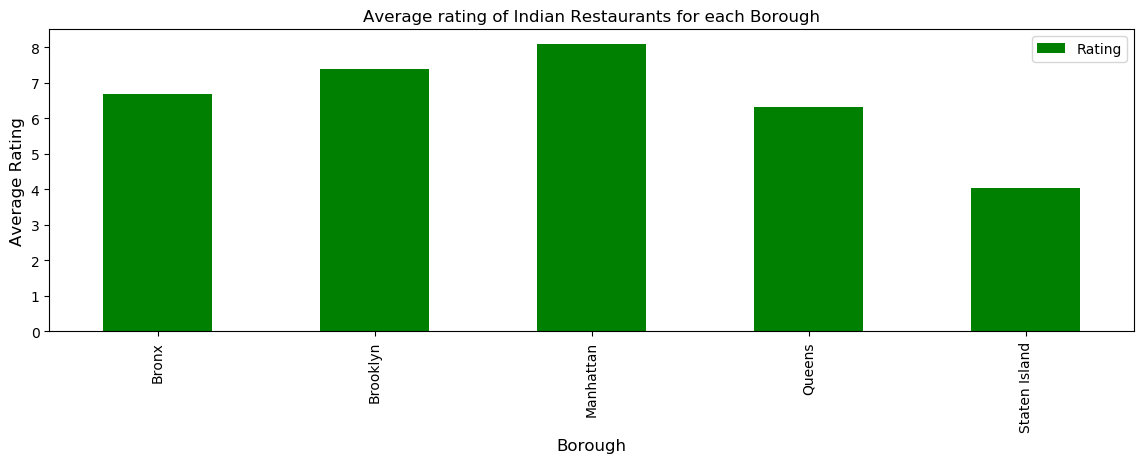

In [37]:
clr = "green"
plt.figure(figsize=(14,4), dpi = 100)
plt.title('Average rating of Indian Restaurants for each Borough')
plt.xlabel('Borough', fontsize = 12)
plt.ylabel('Average Rating', fontsize=12)
indian_rest_stats_ny.groupby('Borough').mean()['Rating'].plot(kind='bar', color=clr)
plt.legend()
plt.show()

Consider all the neighborhoods with average rating greater or equal 8.0 to visualize on a map

In [40]:
ny_neighborhood_stats=ny_neighborhood_stats[ny_neighborhood_stats['Average Rating']>=8.0]
ny_neighborhood_stats

,Neighborhood,Average Rating
1,Bayside,8.200000
2,Boerum Hill,8.100000
7,Chelsea,8.700000
8,Civic Center,8.300000
11,Fort Greene,8.600000
14,Greenwich Village,8.300000
21,Murray Hill,8.100000
22,New Dorp,8.100000
23,Noho,8.800000
24,North Side,8.400000


Join this Dataset to original New York data to get longitude and latitude

In [41]:
ny_neighborhood_stats=pd.merge(ny_neighborhood_stats,ny_data, on='Neighborhood')
ny_neighborhood_stats=ny_neighborhood_stats[['Borough','Neighborhood','Latitude','Longitude','Average Rating']]
ny_neighborhood_stats

,Borough,Neighborhood,Latitude,Longitude,Average Rating
0,Queens,Bayside,40.766041,-73.774274,8.200000
1,Brooklyn,Boerum Hill,40.685683,-73.983748,8.100000
2,Manhattan,Chelsea,40.744035,-74.003116,8.700000
3,Staten Island,Chelsea,40.594726,-74.189560,8.700000
4,Manhattan,Civic Center,40.715229,-74.005415,8.300000
5,Brooklyn,Fort Greene,40.688527,-73.972906,8.600000
6,Manhattan,Greenwich Village,40.726933,-73.999914,8.300000
7,Manhattan,Murray Hill,40.748303,-73.978332,8.100000
8,Queens,Murray Hill,40.764126,-73.812763,8.100000
9,Staten Island,New Dorp,40.572572,-74.116479,8.100000


Show this data on a map

In [42]:
# create map and display it
ny_map = folium.Map(location=geo_location('New York'), zoom_start=12)
# instantiate a feature group for the ratings in the dataframe
rating = folium.map.FeatureGroup()

# loop through the ratings and add each to the neighborhood feature group
for lat, lng, in ny_neighborhood_stats[['Latitude','Longitude']].values:
    rating.add_child(
        folium.CircleMarker(
            [lat, lng],
            radius=10, # define how big you want the circle markers to be
            color='yellow',
            fill=True,
            fill_color='blue',
            fill_opacity=0.6
        )
    )

Add a new field to dataframe for labeling purpose

In [43]:
ny_neighborhood_stats['Label']=ny_neighborhood_stats['Neighborhood']+', '+ny_neighborhood_stats['Borough']+'('+ny_neighborhood_stats['Average Rating'].map(str)+')'
# add pop-up text to each marker on the map
for lat, lng, label in ny_neighborhood_stats[['Latitude','Longitude','Label']].values:
    folium.Marker([lat, lng], popup=label).add_to(ny_map)        
# add ratings to map
ny_map.add_child(rating)

## Results and Conclusion 

- Manhattan and Brooklyn have the best rated Indian restaurants on average. 
- Staten Island and The Bronx have the least amount of Indian restaurants per borough. 
- Sutton Place Hill in Manhattan has the highest number of Indian Restaurants in all of NY. 
- Despite Manhattan having the least number of neighborhoods in all five boroughs, it has the most number of Indian restaurants. 

Based on the above information, we can state that Manhattan and Brooklyn are comparatively better locations for Bangladeshi cuisine in NYC. We can open a Bangladeshi restaurant in Brooklyn which has multiple neighborhoods with average ratings exceeding 8.0 on a scale of 1.0 to 10.0 and has less amount of Indian restaurants than Manhattan, making competition easier. Brooklyn is also close to Jackson Heights, Queens which the main hub for Bangladeshi population. Moreover, the real estate prices in Brooklyn are much cheaper than in Manhattan. 

All of the above analysis is depended on the accuracy of Foursquare data. A more comprehensive analysis would need to incorporate data from other external databases like area-specific population demographics, real estate prices etc.